In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import asyncio
import concurrent.futures
import time

In [2]:
asteroid_df = pd.read_csv("data/asteroid_normalized_small_df.csv")
asteroid_df

,pha,neo,H,e,q,n,moid,diameter,albedo,a,i,spkid,full_name
0,0,0,-7.411043,-0.608738,0.289176,-0.009788,0.306452,314.112492,0.088235,0.010929,0.149533,20000001,1 Ceres (A801 AA)
1,0,0,-6.932515,0.859223,-0.382876,-0.017945,-0.258065,170.929147,0.566176,0.016393,2.991822,20000002,2 Pallas (A802 FA)
2,0,0,-6.282209,1.108738,-0.618740,0.181077,-0.564516,81.471793,1.000000,-0.165756,0.429907,20000003,3 Juno (A804 RA)
3,0,0,-7.466258,-0.503883,-0.357027,0.928222,-0.403226,175.093015,2.535294,-0.728597,-0.253505,20000004,4 Vesta (A807 FA)
4,0,0,-5.171779,0.440777,-0.444265,0.384992,-0.451613,34.494963,1.441176,-0.336976,-0.461449,20000005,5 Astraea (A845 XA)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
137912,0,0,-3.141104,8.195146,6.101777,-3.502333,6.048387,14.246810,-0.073529,795.153005,15.725467,3547316,(2010 BK118)
137913,0,0,-0.319018,7.751456,2.129241,-3.470979,2.258065,0.821692,-0.227941,107.539162,11.220794,3516402,(2010 GW64)
137914,0,0,-1.306748,8.038835,4.859451,-3.497338,5.290323,4.005037,-0.301471,320.107468,10.549065,3517549,(2010 GW147)
137915,0,0,-0.503067,7.960194,0.447496,-3.476215,0.903226,1.029886,-0.191176,121.236794,5.149533,3523334,(2010 JH124)


In [3]:
print(min(asteroid_df['moid']))
print(max(asteroid_df['moid']))

-2.2416612903225808
61.951612903225815


In [4]:
pha_df = asteroid_df[asteroid_df['pha'] == 1]
pha_0_df = asteroid_df[asteroid_df['pha'] == 0].sample(frac=0.1, random_state=1) 
result_df = pd.concat([pha_df, pha_0_df], ignore_index=True)
result_df

,pha,neo,H,e,q,n,moid,diameter,albedo,a,i,spkid,full_name
0,1,1,-0.809816,2.730097,-2.177706,3.329527,-2.169516,0.311283,1.125000,-1.806922,1.498832,20003122,3122 Florence (1981 ET3)
1,1,1,0.699387,3.405825,-2.158320,2.029364,-2.196452,-0.812290,0.779412,-1.320583,0.084112,20039572,39572 (1993 DQ1)
2,1,1,-0.251534,3.544660,-2.172859,1.864600,-2.196129,0.367361,0.007353,-1.244080,4.011682,20089830,89830 (2002 CE)
3,1,1,1.361963,-0.644660,-2.176090,10.337684,-2.208710,-1.061786,1.066176,-3.016393,1.727804,20385186,385186 (1994 AW1)
4,1,1,1.877301,2.993204,-2.142165,2.649266,-2.184677,-1.195769,2.477941,-1.573770,0.362150,20391211,391211 (2006 HZ51)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14070,0,0,0.644172,-0.075728,0.077544,-0.057096,0.064516,-0.020484,-0.294118,0.056466,-0.498832,20183484,183484 (2003 DZ14)
14071,0,0,-0.202454,-1.117476,0.943457,-0.463295,0.887097,0.022834,0.382353,0.499089,0.241822,20143568,143568 (2003 EX52)
14072,0,0,1.036810,0.053398,-0.602585,0.985318,-0.658065,-0.669241,-0.095588,-0.765027,-0.844626,20158932,158932 (2004 RE72)
14073,0,0,-0.079755,-0.766990,0.381260,-0.035889,0.370968,-0.168905,0.845588,0.034608,-0.092290,20110382,110382 (2001 SJ348)


In [51]:
# Initialize a NetworkX graph
G = nx.Graph()

# Add nodes for each asteroid
for idx, row in result_df.iterrows():
    G.add_node(row['spkid'], moid=row['moid'], pha=row['pha'])

In [52]:
# Add Earth as a node
G.add_node("Earth")

In [53]:
# Add edges between Earth and each asteroid with MOID as the weight
for idx, row in pha_df.iterrows():
    G.add_edge("Earth", row['spkid'], distance=row['moid'])

In [72]:
node_colors = []
node_size = []

for node in G.nodes():
    if node == "Earth":
        node_colors.append('tab:blue')
        node_size.append(100)
    else:
        # Retrieve 'pha' value for the current node
        pha_value = G.nodes[node].get('pha')
        
        # Set color and size based on 'pha' value
        if pha_value == 0:
            node_colors.append('tab:olive')   # Color for pha = 1
            node_size.append(20)           # Larger size for pha = 1
        elif pha_value == 1:
            node_colors.append('tab:red') # Color for pha = 0
            node_size.append(50)           # Smaller size for pha = 0
        else:
            # Default color/size if 'pha' attribute is missing or unknown
            node_colors.append('tab:gray')
            node_size.append(20)

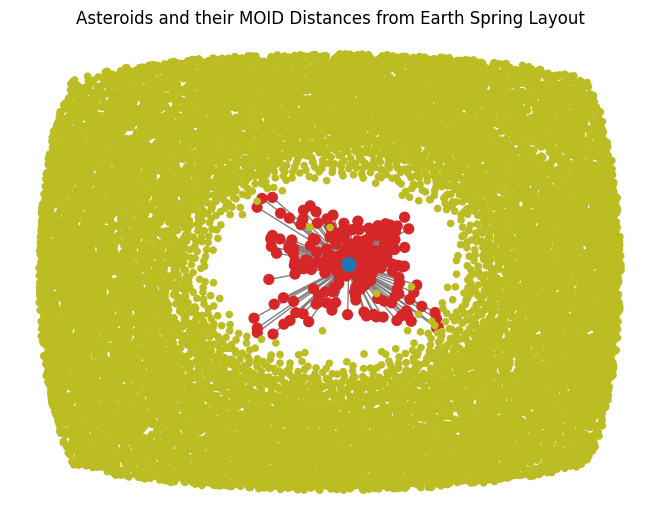

In [76]:
pos = nx.spring_layout(G, iterations= 5)
nx.draw(G, pos, with_labels=False, node_size = node_size, node_color=node_colors, edge_color='gray')

plt.title("Asteroids and their MOID Distances from Earth Spring Layout")
plt.show()